# Chess Winner Prediction Using ML Models 

The goal is to predict chess matches winner using the available data from lichess dataset. And also, what is the impact of the opening (strategy and turns taken) in winning the game. You can inspect and download the dataset from [this url](https://www.kaggle.com/datasets/datasnaek/chess).

**TODO: Improve introduction**

**TODO: understand scikit-learn pipelines. [ref_1](https://scikit-learn.org/stable/modules/compose.html#pipeline), [ref_2](https://medium.com/data-hackers/como-usar-pipelines-no-scikit-learn-1398a4cc6ae9)**

## About Dataset

Extracted from official dataset index.

**General Info**

This is a set of just over 20,000 games collected from a selection of users on the site Lichess.org, and how to collect more. This set contains the following features:


- Game ID;
- Rated (T/F);
- Start Time;
- End Time;
- Number of Turns;
- Game Status;
- Winner;
- Time Increment;
- White Player ID;
- White Player Rating;
- Black Player ID;
- Black Player Rating;
- All Moves in Standard Chess Notation;
- Opening Eco (Standardised Code for any given opening, [list here](https://www.365chess.com/eco.php));
- Opening Name;
- Opening Ply (Number of moves in the opening phase)

Data was collected using the [Lichess API](https://github.com/ornicar/lila), which enables collection of any given users game history.

**Possible Uses**

Lots of information is contained within a single chess game, let alone a full dataset of multiple games. It is primarily a game of patterns, and data science is all about detecting patterns in data, which is why chess has been one of the most invested in areas of AI in the past. This dataset collects all of the information available from 20,000 games and presents it in a format that is easy to process for analysis of, for example, what allows a player to win as black or white, how much meta (out-of-game) factors affect a game, the relationship between openings and victory for black and white and more.

## Imports

In [199]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# only on notebooks
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

## Loading, exploring and preprocessing data

In [200]:
chess = pd.read_csv('games.csv')

In [201]:
chess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


### Dropping unused columns

Some features, like unique match and player's ```id```, if match was ```rated``` or not, and timestamps are not useful to us. Therefore, they must be removed. Also, ```moves``` can result in some sort of data leakage, and will be removed aswell.

In [202]:
chess = chess.drop(['id', 'rated', 'created_at', 'last_move_at', 'increment_code', 'white_id', 'black_id', 'opening_name', 'moves'], axis=1)
chess.head()

,turns,victory_status,winner,white_rating,black_rating,opening_eco,opening_ply
0,13,outoftime,white,1500,1191,D10,5
1,16,resign,black,1322,1261,B00,4
2,61,mate,white,1496,1500,C20,3
3,61,mate,white,1439,1454,D02,3
4,95,mate,white,1523,1469,C41,5


In [203]:
chess.describe()

,turns,white_rating,black_rating,opening_ply
count,20058.000000,20058.000000,20058.000000,20058.000000
mean,60.465999,1596.631868,1588.831987,4.816981
std,33.570585,291.253376,291.036126,2.797152
min,1.000000,784.000000,789.000000,1.000000
25%,37.000000,1398.000000,1391.000000,3.000000
50%,55.000000,1567.000000,1562.000000,4.000000
75%,79.000000,1793.000000,1784.000000,6.000000
max,349.000000,2700.000000,2723.000000,28.000000


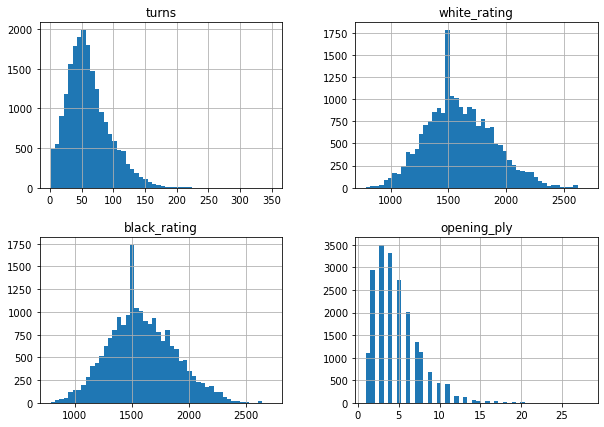

In [204]:
chess.hist(bins=50, figsize=(10,7))
plt.show()

In [205]:
chess['opening_eco'].unique().size

365

### Grouping opening ecos by categories

In [206]:
def get_rows_by_opening(df, code):
    return df['opening_eco'][df['opening_eco'].str.startswith(code)]

In [207]:
def group_ecos_by_cat(cat_array, df):
    openings = []
    for cat in cat_array:
        opening = get_rows_by_opening(df, cat)
        openings.append(opening)
    
    for idx, op in enumerate(openings, start=1):
        for row in op:
            df['opening_eco'] = df['opening_eco'].replace(row, idx)
    return df

In [208]:
cat_arr = ['A', 'B', 'C', 'D', 'E']
group_ecos_by_cat(cat_arr, chess)

,turns,victory_status,winner,white_rating,black_rating,opening_eco,opening_ply
0,13,outoftime,white,1500,1191,4,5
1,16,resign,black,1322,1261,2,4
2,61,mate,white,1496,1500,3,3
3,61,mate,white,1439,1454,4,3
4,95,mate,white,1523,1469,3,5
...,...,...,...,...,...,...,...
20053,24,resign,white,1691,1220,1,2
20054,82,mate,black,1233,1196,1,2
20055,35,mate,white,1219,1286,4,3
20056,109,resign,white,1360,1227,2,4


In [209]:
chess

,turns,victory_status,winner,white_rating,black_rating,opening_eco,opening_ply
0,13,outoftime,white,1500,1191,4,5
1,16,resign,black,1322,1261,2,4
2,61,mate,white,1496,1500,3,3
3,61,mate,white,1439,1454,4,3
4,95,mate,white,1523,1469,3,5
...,...,...,...,...,...,...,...
20053,24,resign,white,1691,1220,1,2
20054,82,mate,black,1233,1196,1,2
20055,35,mate,white,1219,1286,4,3
20056,109,resign,white,1360,1227,2,4


In [210]:
print(chess['winner'].unique())
print(chess['winner'].unique().size)

['white' 'black' 'draw']
3


In [211]:
print(chess['victory_status'].unique())
print(chess['victory_status'].unique().size)

['outoftime' 'resign' 'mate' 'draw']
4


### One-Hot Encoding Categorical Variables

In [212]:
# https://www.statology.org/one-hot-encoding-in-python/

def cat_encoder(df, var_array):
    encoded, categories = var_array.factorize()
    print('first values: ')
    print(encoded[:10])
    print(categories)
    encoder = OneHotEncoder()
    one_hot = encoder.fit_transform(encoded.reshape(-1, 1))
    one_hot_df = pd.DataFrame(one_hot.toarray())
    return df.join(one_hot_df)

In [213]:
chess = cat_encoder(chess, chess['winner'])

first values: 
[0 1 0 0 0 2 0 1 1 0]
Index(['white', 'black', 'draw'], dtype='object')


In [214]:
# keeping winner bcause its our y
chess.rename({0: 'white_wins', 1: 'black_wins', 2: 'draw'}, axis=1, inplace=True)

Dropping draw column to avoid redundancy

In [215]:
chess.drop(['draw'], axis=1, inplace=True)

In [216]:
chess.head()

,turns,victory_status,winner,white_rating,black_rating,opening_eco,opening_ply,white_wins,black_wins
0,13,outoftime,white,1500,1191,4,5,1.0,0.0
1,16,resign,black,1322,1261,2,4,0.0,1.0
2,61,mate,white,1496,1500,3,3,1.0,0.0
3,61,mate,white,1439,1454,4,3,1.0,0.0
4,95,mate,white,1523,1469,3,5,1.0,0.0


In [217]:
print(chess['victory_status'].unique())
print(chess['victory_status'].unique().size)

['outoftime' 'resign' 'mate' 'draw']
4


In [218]:
chess = cat_encoder(chess, chess['victory_status'])
chess.drop('victory_status', axis=1, inplace=True)
chess.rename({0: 'outoftime', 1: 'resign', 2: 'mate', 3: 'draw'}, axis=1, inplace=True)

first values: 
[0 1 2 2 2 3 1 1 1 2]
Index(['outoftime', 'resign', 'mate', 'draw'], dtype='object')


In [219]:
chess.head()

,turns,winner,white_rating,black_rating,opening_eco,opening_ply,white_wins,black_wins,outoftime,resign,mate,draw
0,13,white,1500,1191,4,5,1.0,0.0,1.0,0.0,0.0,0.0
1,16,black,1322,1261,2,4,0.0,1.0,0.0,1.0,0.0,0.0
2,61,white,1496,1500,3,3,1.0,0.0,0.0,0.0,1.0,0.0
3,61,white,1439,1454,4,3,1.0,0.0,0.0,0.0,1.0,0.0
4,95,white,1523,1469,3,5,1.0,0.0,0.0,0.0,1.0,0.0


### Further exploring

In [220]:
train_set, test_set = train_test_split(chess, test_size=0.2, random_state=42)

In [221]:
exp_chess = train_set.copy()

In [222]:
corr_matrix = exp_chess.corr()

In [223]:
corr_matrix['white_wins'].sort_values(ascending=False)

white_wins      1.000000
white_rating    0.126157
resign          0.060981
mate            0.037387
opening_eco     0.019885
opening_ply     0.013721
outoftime      -0.009369
turns          -0.075366
black_rating   -0.171295
draw           -0.216829
black_wins     -0.909616
Name: white_wins, dtype: float64

In [224]:
corr_matrix['black_wins'].sort_values(ascending=False)

black_wins      1.000000
black_rating    0.155364
resign          0.045273
mate            0.026566
outoftime       0.023183
turns           0.007362
opening_eco    -0.015103
opening_ply    -0.021261
white_rating   -0.146594
draw           -0.198514
white_wins     -0.909616
Name: black_wins, dtype: float64

#### Exploratory assumptions

* There is no apparent linear relations between features.
* It's easier to win on white side, even if you are outranked by your opponent.
* The most common method to win is ```resign```.
* Black have better chances on longer games, winning by ```outoftime```.
* Simetrically, white have better chances on short ```opening_ply```.
* The longer the game, more chances black have to win.


### Finishing dataset exploration

In [225]:
chess.drop(['white_wins', 'black_wins', 'draw'], axis=1, inplace=True)

In [226]:
draws = chess.loc[chess['winner'] == 'draw']
chess.drop(draws.index, inplace=True)

In [227]:
chess

,turns,winner,white_rating,black_rating,opening_eco,opening_ply,outoftime,resign,mate
0,13,white,1500,1191,4,5,1.0,0.0,0.0
1,16,black,1322,1261,2,4,0.0,1.0,0.0
2,61,white,1496,1500,3,3,0.0,0.0,1.0
3,61,white,1439,1454,4,3,0.0,0.0,1.0
4,95,white,1523,1469,3,5,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
20053,24,white,1691,1220,1,2,0.0,1.0,0.0
20054,82,black,1233,1196,1,2,0.0,0.0,1.0
20055,35,white,1219,1286,4,3,0.0,0.0,1.0
20056,109,white,1360,1227,2,4,0.0,1.0,0.0


In [228]:
le = LabelEncoder()
chess['winner'] = le.fit_transform(chess['winner'])
# 1: white, 0: black

chess

,turns,winner,white_rating,black_rating,opening_eco,opening_ply,outoftime,resign,mate
0,13,1,1500,1191,4,5,1.0,0.0,0.0
1,16,0,1322,1261,2,4,0.0,1.0,0.0
2,61,1,1496,1500,3,3,0.0,0.0,1.0
3,61,1,1439,1454,4,3,0.0,0.0,1.0
4,95,1,1523,1469,3,5,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
20053,24,1,1691,1220,1,2,0.0,1.0,0.0
20054,82,0,1233,1196,1,2,0.0,0.0,1.0
20055,35,1,1219,1286,4,3,0.0,0.0,1.0
20056,109,1,1360,1227,2,4,0.0,1.0,0.0


## Splitting Dataset using Holdout Method 

In [229]:
chess_data = chess.loc[:, chess.columns != 'winner']
chess_labels = chess['winner']

In [230]:
X_train, X_test, y_train, y_test = train_test_split(chess_data, chess_labels, test_size=0.2, random_state=42)

### Feature Scaling

Some features range from 0 to 2, while others go from 400 to 2500. This is not ideal because machine learning algorithms could weight them out and give non-existing importance to larger features.

We'll use scikit-learn's ```MinMaxScaler``` to scale our data in the range of zero to one. This is ideal to train neural networks.

In [231]:
X_train.head()

,turns,white_rating,black_rating,opening_eco,opening_ply,outoftime,resign,mate
2289,104,2066,1937,1,4,0.0,1.0,0.0
10874,101,1400,1246,3,3,0.0,0.0,1.0
660,78,1380,2239,4,4,0.0,1.0,0.0
18080,36,1307,1389,3,3,0.0,1.0,0.0
3381,76,1846,1977,3,5,0.0,1.0,0.0


In [232]:
min_max_scaler = preprocessing.MinMaxScaler()
# X_train[X_train.columns] = min_max_scaler.fit_transform(X_train[X_train.columns])
X_train.head()

,turns,white_rating,black_rating,opening_eco,opening_ply,outoftime,resign,mate
2289,104,2066,1937,1,4,0.0,1.0,0.0
10874,101,1400,1246,3,3,0.0,0.0,1.0
660,78,1380,2239,4,4,0.0,1.0,0.0
18080,36,1307,1389,3,3,0.0,1.0,0.0
3381,76,1846,1977,3,5,0.0,1.0,0.0


After fitting scaler to train samples, we can apply to entire dataset.

In [233]:
X_test.head()

,turns,white_rating,black_rating,opening_eco,opening_ply,outoftime,resign,mate
15425,43,1880,1490,4,9,0.0,0.0,1.0
15370,77,1271,1328,3,8,0.0,1.0,0.0
4744,24,1681,1388,2,4,0.0,1.0,0.0
18483,48,1847,2036,1,4,0.0,1.0,0.0
1521,40,1424,1356,4,6,0.0,0.0,1.0


In [234]:
# X_test[X_test.columns] = min_max_scaler.transform(X_test[X_test.columns])
X_test.head()

,turns,white_rating,black_rating,opening_eco,opening_ply,outoftime,resign,mate
15425,43,1880,1490,4,9,0.0,0.0,1.0
15370,77,1271,1328,3,8,0.0,1.0,0.0
4744,24,1681,1388,2,4,0.0,1.0,0.0
18483,48,1847,2036,1,4,0.0,1.0,0.0
1521,40,1424,1356,4,6,0.0,0.0,1.0


## Selecting and Training Models

We will evaluate performance using cross validation on the following models:

- K-nearest Neighbors
- Decision Tree
- Naive Bayes
- Support Vector Machine
- Neural Networks

In [235]:
def train_eval_model(model):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    return (train_acc, test_acc)

### K-nearest Neighbors

In [236]:
knn_model = KNeighborsClassifier(n_neighbors=3)

knn_3_train_acc, knn_3_test_acc = train_eval_model(knn_model)
print('train accuracy: ', knn_3_train_acc)
print('test accuracy: ', knn_3_test_acc)

train accuracy:  0.7983776004186838
test accuracy:  0.6245421245421245


#### Cross-validation on best K

In [237]:
parameters = {'n_neighbors': range(1, 50)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)

In [238]:
train_grid_acc, test_grid_acc = train_eval_model(gridsearch)

print('train accuracy: ', train_grid_acc)
print('test accuracy: ', test_grid_acc)

train accuracy:  0.6703519560382049
test accuracy:  0.6436420722135008


In [239]:
gridsearch.best_params_

{'n_neighbors': 45}

### Decision Tree Classifier

In [240]:
dec_tree = DecisionTreeClassifier()
train_tree_acc, test_tree_acc = train_eval_model(dec_tree)
print('train accuracy: ', train_tree_acc)
print('test accuracy: ', test_tree_acc)

train accuracy:  0.9999345806620437
test accuracy:  0.6279434850863422


### Naive Bayes Classifier

In [241]:
from sklearn.naive_bayes import GaussianNB

gauss_nb_model = GaussianNB()

train_nb_acc, test_nb_acc = train_eval_model(gauss_nb_model)
print('train acc: ', train_nb_acc)
print('test acc: ', test_nb_acc)

train acc:  0.6170351956038205
test acc:  0.6130298273155416


In [242]:
from sklearn.naive_bayes import ComplementNB

comp_nb_model = ComplementNB()
train_nb_acc, test_nb_acc = train_eval_model(comp_nb_model)
print('train acc: ', train_nb_acc)
print('test acc: ', test_nb_acc)

train acc:  0.6513149286929216
test acc:  0.652276295133438


### Support Vector Machine

In [243]:
from sklearn import svm

svm_model = svm.NuSVC(gamma='auto')
train_svm_acc, test_svm_acc = train_eval_model(svm_model)
print('train acc: ', train_svm_acc)
print('test acc: ', test_svm_acc)

train acc:  0.999345806620437
test acc:  0.5570381998953428


### Neural Network

In [244]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)
train_nn_acc, test_nn_acc = train_eval_model(nn_model)
print('train acc: ', train_nn_acc)
print('test acc: ', test_nn_acc)

train acc:  0.5240743163679183
test acc:  0.5206698063840921


## Back to EDA

In [245]:
chess['winner'].value_counts()

1    10001
0     9107
Name: winner, dtype: int64

Looks like there is no class inbalance